# Model inversion for prep_aria.py (ARIAtools > Mintpy)

Notebook to preform inversion of double-difference model observations to get model values at SAR acquisitions dates
1. generate double-difference stack from existing ERA5.h5 stack
2. invert double-difference pairs to obtain SAR acquisitions model values (in this case tropospheric total delay)

In [1]:
# Load needed modules
import numpy as np
from matplotlib import pyplot as plt

#mintpy modules
from mintpy.objects import ifgramStack, cluster
from mintpy.utils import readfile, ptime, writefile

In [2]:
# Get needed metadata from interferogram stack - pairs, dates

# Load ifg stack data
stack_obj = ifgramStack('inputs/ifgramStack.h5')
stack_obj.open(print_msg=False)
# Get metadata
metadata = stack_obj.get_metadata()
date_list = stack_obj.get_date_list() # get SAR acquisiton dates
date12_list = stack_obj.get_date12_list() # get ifg pairs
bperp12 = stack_obj.pbaseIfgram # get ifg pair perpendicular baselines
bperp_list = stack_obj.get_perp_baseline_timeseries() # get SAR acquisitions perpendicular baseline (first date is zero)
length, width = stack_obj.length, stack_obj.width # raster dimensions
#reference point
ref_y, ref_x = int(metadata['REF_Y']), int(metadata['REF_X'])


## 1. Create double-difference model observations

In [4]:
def generate_model_doublediff(model_input_h5 : str,
                              model_output_name : str,
                              date12_list : list,
                              bperp12 : np.ndarray,
                              length : np.int16,
                              width : np.int16,
                              metadata : dict) -> None:
    import h5py
    from tqdm import tqdm

    # Function to create double-diff
    def _make_diff(model_stack, date12):
        date1, date2 = ptime.yyyymmdd(date12.split('_'))
        # read date1
        tropo1 = model_stack.read(date1, print_msg=False)
        tropo2 = model_stack.read(date2, print_msg=False)
        dif_tropo = tropo2 - tropo1 
        #Re-reference - SKIP for now, but should be taken into consideration
        dif_tropo -= dif_tropo[ref_y, ref_x]

        return dif_tropo
    

    # Create double-difference model.h5 file
    metadata['FILE_TYPE'] = 'ifgramStack'
    metadata['UNIT'] = 'm'
    #use the first date as reference
    metadata['REF_DATE'] = date12_list[0]
    num_pairs = bperp12.shape[0]

    #get dates numpy array for h5
    date12_array = np.array(list(map(lambda x: x.split('_'), date12_list)), dtype='S8')

    # creat dict for model.h5 layout
    # NOTE: Need to use layer naming unwrappedPhase as ifgramStack object does not support
    # other options at the moment
    # NOTE: maybe could play with dropIfgram to filter data, leave only sequentials
    # but pay attentation to have connected network
    ds_name_dict = {
        "date"       : [date12_array.dtype, (num_pairs, 2), date12_array],
        "bperp"      : [np.float32,  (num_pairs,), bperp12],
        "dropIfgram" : [np.bool_, (num_pairs,), np.bool_(np.ones(num_pairs))],
        "unwrapPhase" : [np.float32,  (num_pairs, length, width), None],
    }
    print(f'Creating {model_output_name}.h5')
    writefile.layout_hdf5(model_output_name + '.h5', ds_name_dict, metadata=metadata)

    # Double-differenceing model observations
    # Open model file
    modelObj = readfile.timeseries(model_input_h5)

    # Writing to h5 
    with h5py.File(model_output_name + '.h5','a') as f:
        for i, date12 in tqdm(enumerate(date12_list), total=len(date12_list)):
            f['unwrapPhase'][i] =_make_diff(modelObj, date12)
    

In [5]:
print("\033[1m" + 'Creating double-differeince model observations for each ifg pair' + "\033[0m")
generate_model_doublediff('inputs/ERA5.h5',
                          'rERA5.h5',
                          date12_list,
                          bperp12,
                          length,
                          width,
                          metadata)

Creating double-differeince model observations for each ifg pair
Creating rERA5.h5.h5
--------------------------------------------------
create HDF5 file: rERA5.h5.h5 with w mode
create dataset  : date        of |S8                       in size of (1602, 2)            with compression = None
create dataset  : bperp       of <class 'numpy.float32'>   in size of (1602,)              with compression = None
create dataset  : dropIfgram  of <class 'numpy.bool_'>     in size of (1602,)              with compression = None
create dataset  : unwrapPhase of <class 'numpy.float32'>   in size of (1602, 3926, 5534)   with compression = None
close  HDF5 file: rERA5.h5.h5


100%|██████████| 1602/1602 [22:49<00:00,  1.17it/s]


## 2. Invert double-difference model observations to obtain relative ones for each SAR acquisition date with respect to defined reference date

In [ ]:
# Function based on run_ifgram_inversion(inps) in mintpy/ifgram_inversion.py
def run_ifgram_inversion(model_stackFile : str,
                         model_output: str,
                         cluster_flag : bool = False,
                         cluster_num_workers : int = 4) -> None:
    from tqdm import tqdm
    # Create hdf layout for the inversion output

    #  1.1 open double-difference model.h5 stack
    '''
     hdf file needs to have:
     ds_name_dict = {
        "date"       : [date12_array.dtype, (num_pairs, 2), date12_array],
        "bperp"      : [np.float32,  (num_pairs,), bperp12],
        "dropIfgram" : [np.bool_, (num_pairs,), np.bool_(np.ones(num_pairs))],
        "unwrapPhase" : [np.float32,  (num_pairs, length, width), None],
    }
    ''' 
    modelObj = ifgramStack(model_stackFile)  #model.h5
    modelObj.open()

    # get dates
    date12_list = modelObj.get_date12_list(dropIfgram=True)
    date_list = modelObj.get_date_list(dropIfgram=False)
    length, width = modelObj.length, modelObj.width

    # 1.2 design matrix
    A = modelObj.get_design_matrix4timeseries(date12_list)[0]
    num_pair, num_date = A.shape[0], A.shape[1]+1
    print('number of interferograms: {}'.format(num_pair))
    print('number of acquisitions  : {}'.format(num_date))
    print('number of lines   : {}'.format(length))
    print('number of columns : {}'.format(width))

    # initiate output
    meta = dict(modelObj.metadata)
    meta['FILE_TYPE'] = 'timeseries'
    meta['UNIT'] = 'm'
    meta['REF_DATE'] = date_list[0]

    dates = np.array(date_list, dtype=np.string_)
    pbase = modelObj.get_perp_baseline_timeseries(dropIfgram=False)
    # wrapping factor 
    phase2range = -1 * float(modelObj.metadata['WAVELENGTH']) / (4.*np.pi) 

    ds_name_dict = {
    "date"       : [dates.dtype, (num_date,), dates],
    "bperp"      : [np.float32,  (num_date,), pbase],
    "timeseries" : [np.float32,  (num_date, length, width), None],
    }
    writefile.layout_hdf5(model_output, ds_name_dict, metadata=meta)

    # 2. INVERSION
    from mintpy.ifgram_inversion import run_ifgram_inversion_patch
    # Get reference pixel value
    refPhase = modelObj.get_reference_phase(unwDatasetName='unwrapPhase',
                                            dropIfgram=True)

    box_list, num_box = modelObj.split2boxes(max_memory=2) #max 2gb

    # 2.1 prepare the input arguments for *_patch()
    # set offset into obs_ds_name to follow offset inv
    data_kwargs = {
        "ifgram_file"       : model_stackFile,
        "obs_ds_name"       : 'unwrapPhase',
        'ref_phase'         : refPhase,
        "weight_func"       : 'no',
    }
    # 2.2 invert / write block-by-block
    for i, box in tqdm(enumerate(box_list), total=len(box_list)):
        box_wid = box[2] - box[0]
        box_len = box[3] - box[1]
        if num_box > 1:
            print('\n------- processing patch {} out of {} --------------'.format(i+1, num_box))
            print('box width:  {}'.format(box_wid))
            print('box length: {}'.format(box_len))

        # update box argument in the input data
        data_kwargs['box'] = box

        if not cluster_flag:
            # non-parallel
            ts, ts_cov, inv_quality, num_inv_obs = run_ifgram_inversion_patch(**data_kwargs)[:-1]

        else:
            # parallel
            print('\n\n------- start parallel processing using Dask -------')

            # initiate the output data
            ts = np.zeros((num_date, box_len, box_wid), np.float32)
            ts_cov =  None
            inv_quality = np.zeros((box_len, box_wid), np.float32)
            num_inv_obs = np.zeros((box_len, box_wid), np.float32)

            # initiate dask cluster and client
            cluster_obj = cluster.DaskCluster('local', str(cluster_num_workers))
            cluster_obj.open()

            # run dask
            ts, ts_cov, inv_quality, num_inv_obs = cluster_obj.run(
                func=run_ifgram_inversion_patch,
                func_data=data_kwargs,
                results=[ts, ts_cov, inv_quality, num_inv_obs])

            # close dask cluster and client
            cluster_obj.close()

            print('------- finished parallel processing -------\n\n')

        # revert conversion from radians to meters as it is not needed
        # Note: compensate for ifgram_inversion.py line 909
        # double-difference model observations are in meters not radians
        print('returning model observations unit from radian to meter')
        ts = ts / phase2range

        # write it local
        block = [0, num_date, box[1], box[3], box[0], box[2]]
        writefile.write_hdf5_block(model_output,
                                   data=ts,
                                   datasetName='timeseries',
                                   block=block)

: 

In [9]:
print("\033[1m" + 'Invert double-difference model observations' + "\033[0m")
run_ifgram_inversion('rERA5.h5', 'tERA5.h5')

Invert double-difference model observations
open ifgramStack file: rERA5.h5
number of interferograms: 1602
number of acquisitions  : 308
number of lines   : 3926
number of columns : 5534
--------------------------------------------------
create HDF5 file: tERA5.h5 with w mode
create dataset  : date       of |S8                       in size of (308,)               with compression = None
create dataset  : bperp      of <class 'numpy.float32'>   in size of (308,)               with compression = None
create dataset  : timeseries of <class 'numpy.float32'>   in size of (308, 3926, 5534)    with compression = None
close  HDF5 file: tERA5.h5
reference pixel in y/x: (2764, 2142) from dataset: unwrapPhase
maximum memory size: 2.0E+00 GB
split 3926 lines into 197 patches for processing
    with each patch up to 20 lines

------- processing patch 1 out of 197 --------------
box width:  5534
box length: 20
reading unwrapPhase in (0, 0, 5534, 20) * 1602 ...
use input reference value
convert zero

# 3. Vizualize

In [102]:
# Vizualize
def plot_tropo(input_era, inv_era, ref_era):
    # Reference absolute model obs to the reference date
    ie1 = (input_era - ref_era).copy()
    ie2 = inv_era.copy() #/ phase2range

    #re-reference to the same reference pixel
    clim= [-0.03, 0.03]
    ie1 -= ie1[ref_y, ref_x]
    fig, ax = plt.subplots(1, 3, sharey=True)
    im1 = ax[0].imshow(ie1, clim=clim)
    im2 = ax[1].imshow(ie2, clim=clim)
    im3 = ax[2].imshow(ie1 - ie2, clim=clim) 

    ax[0].set_title('ERA5')
    ax[1].set_title('invERA5')
    ax[2].set_title('ERA5 - invERA5')

    fig.colorbar(im1, ax=ax[0], location='bottom')
    fig.colorbar(im2, ax=ax[1], location='bottom')
    fig.colorbar(im3, ax=ax[2], location='bottom')

#plot

era5 = readfile.read('inputs/ERA5.h5', datasetName='timeseries')
t_era5 =readfile.read('t_ERA5.h5', datasetName='timeseries')

4

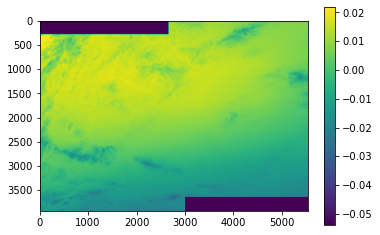

In [6]:
dd = era5[0][2] - era5[0][0]
dd -= dd[ref_y, ref_x]

plt.imshow(dd)
plt.colorbar()

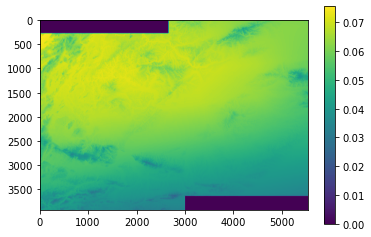

In [9]:
plt.imshow(era5[0][2] - era5[0][0])
plt.colorbar()

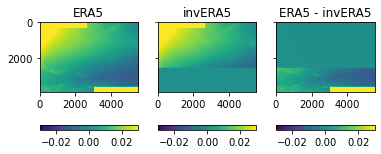

In [18]:
plot_tropo(era5[0][5], t_era5[0][5], era5[0][0])

/tmp/ipykernel_48744/2001413207.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 3, sharey=True)


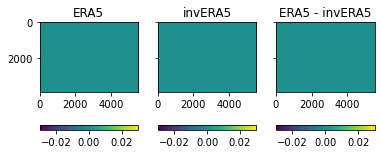

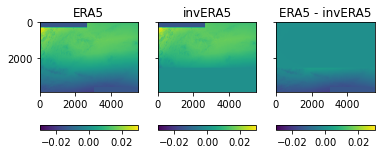

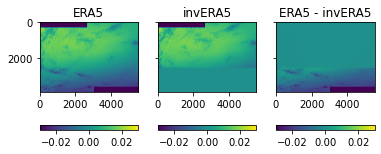

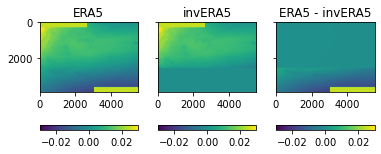

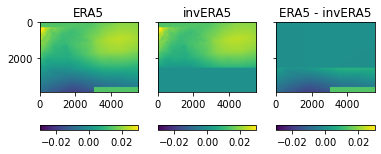

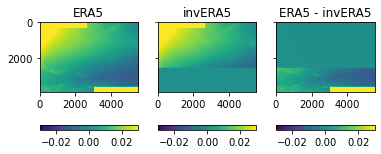

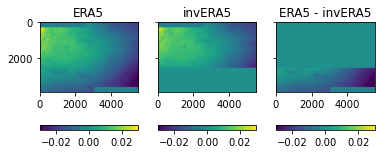

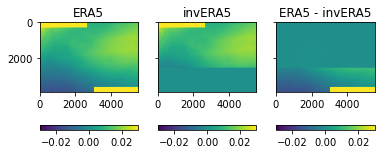

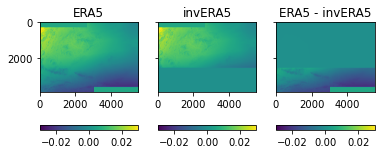

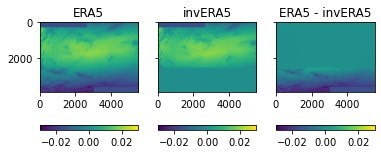

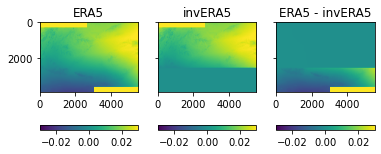

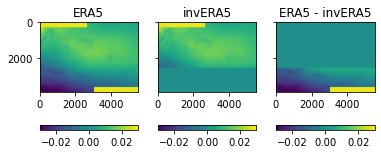

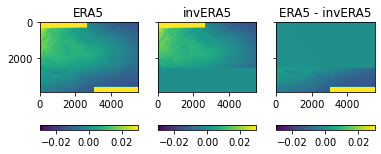

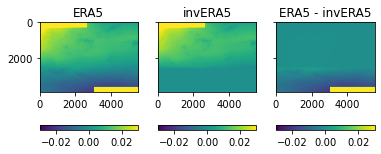

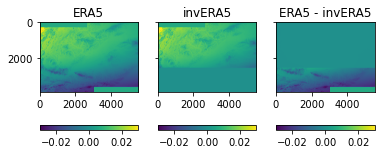

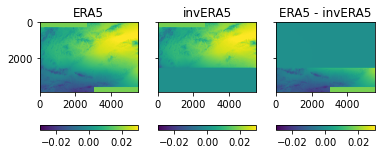

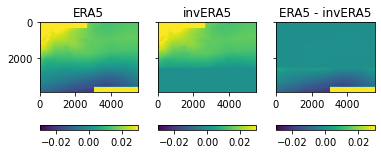

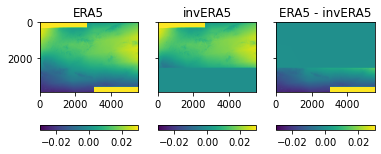

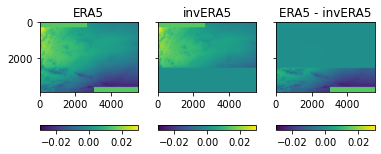

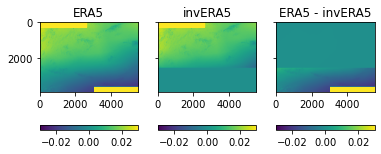

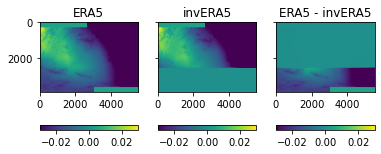

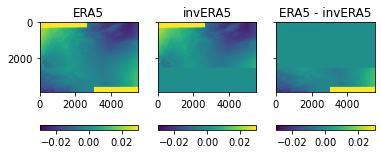

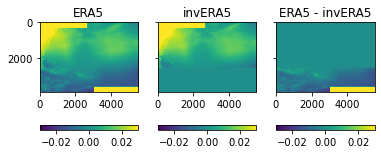

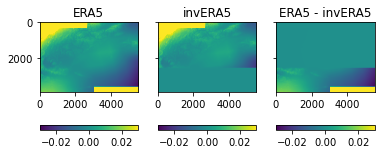

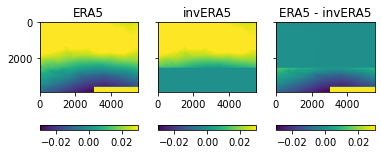

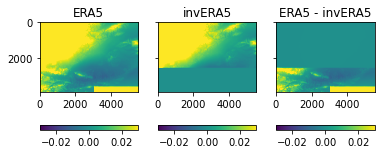

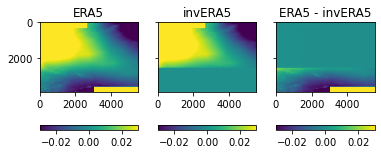

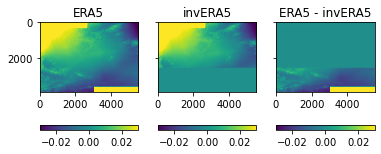

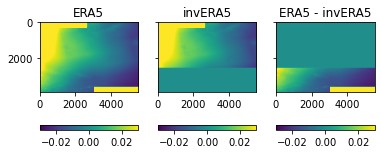

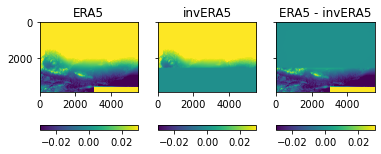

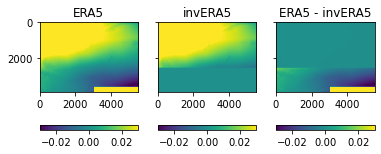

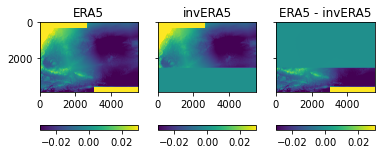

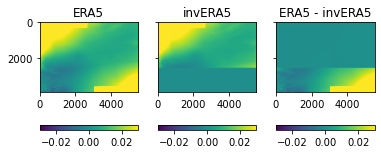

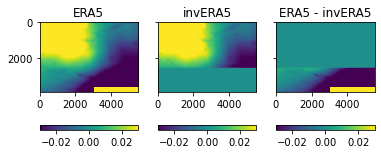

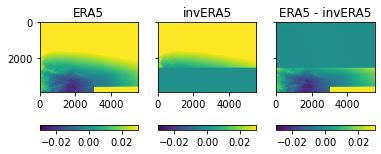

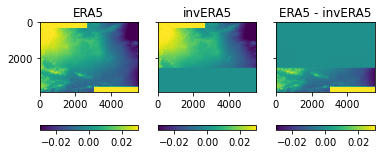

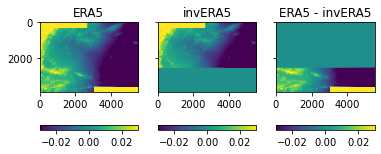

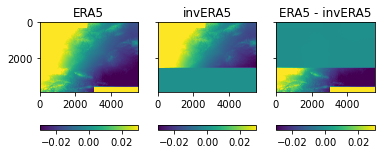

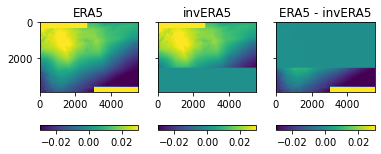

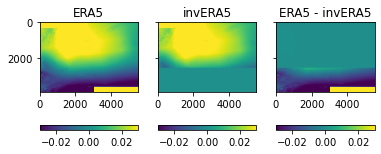

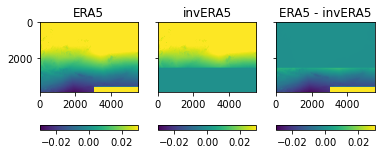

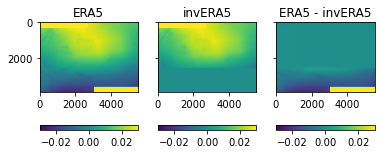

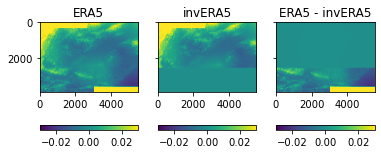

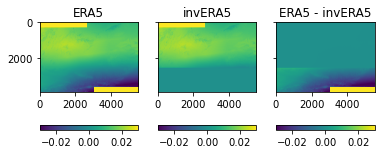

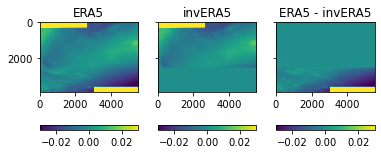

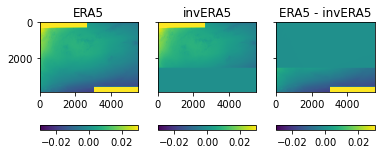

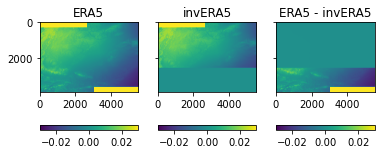

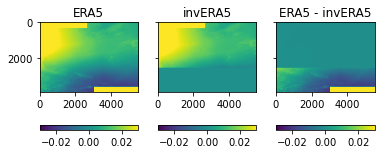

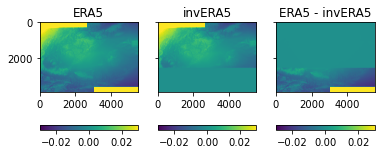

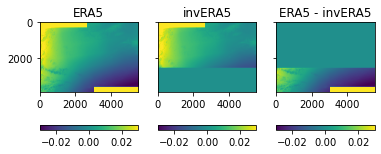

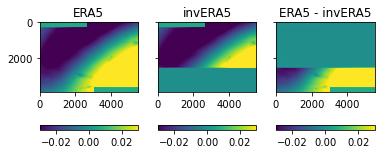

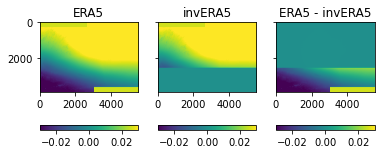

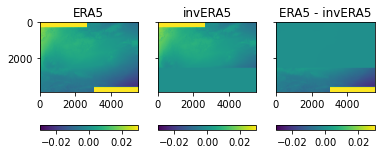

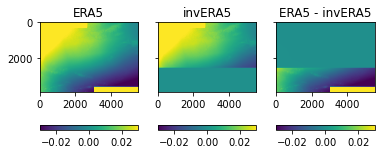

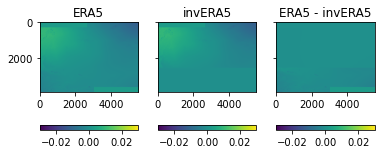

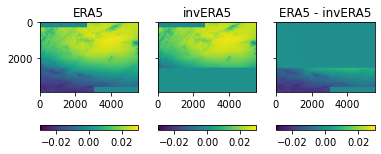

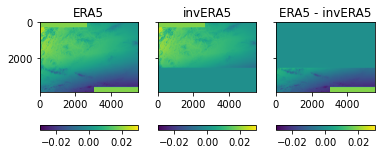

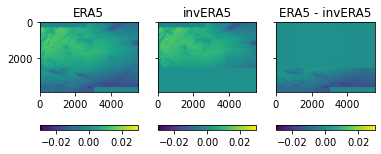

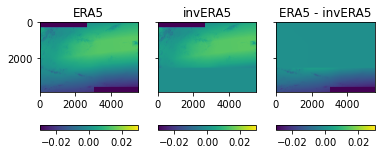

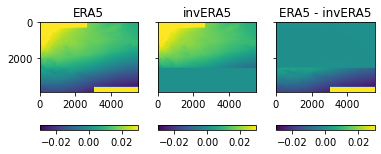

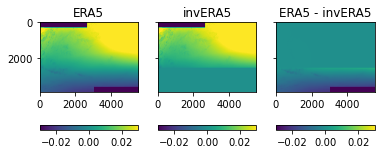

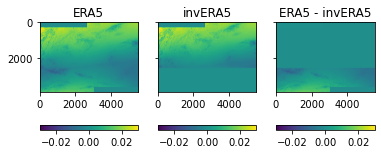

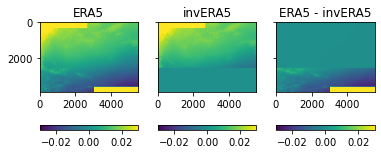

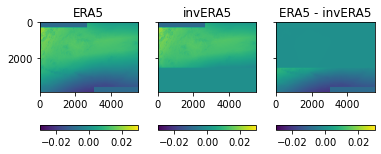

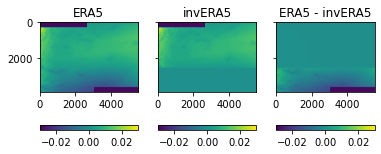

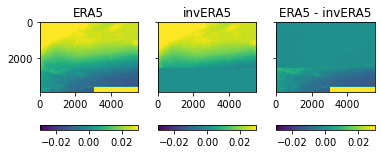

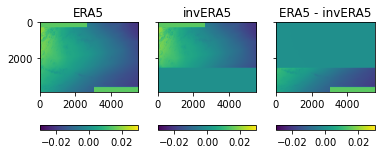

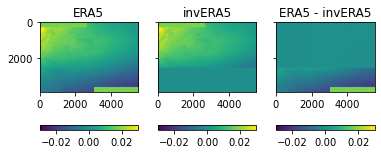

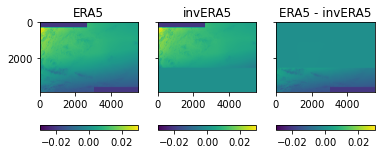

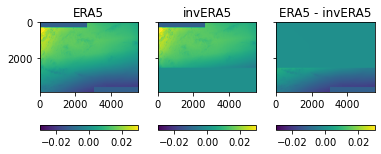

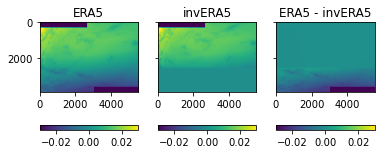

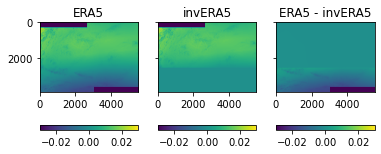

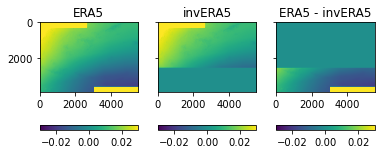

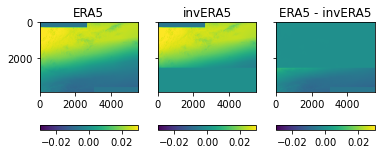

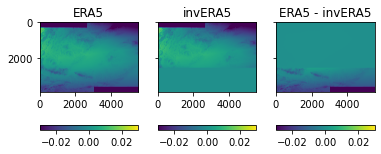

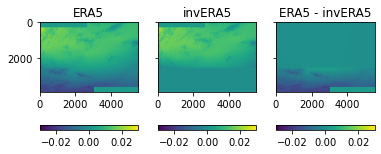

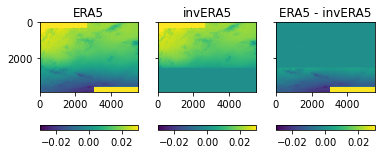

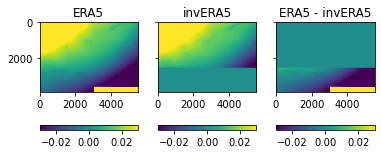

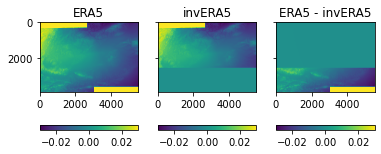

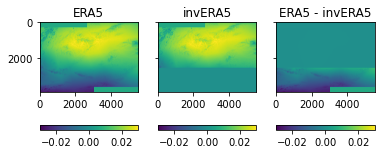

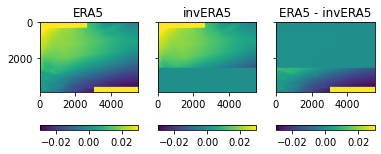

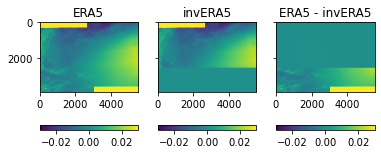

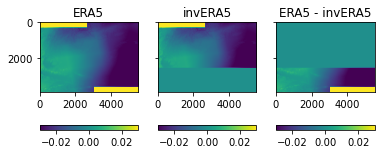

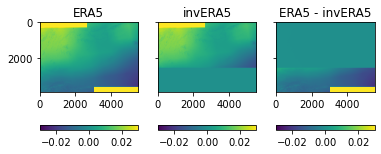

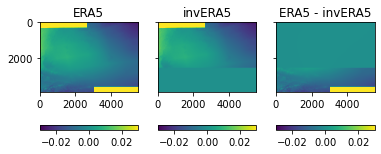

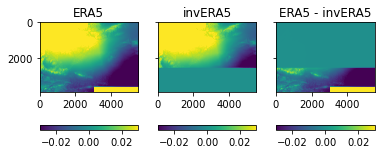

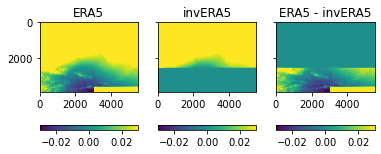

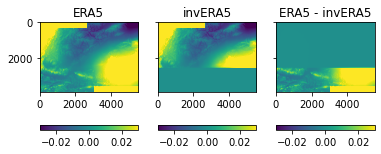

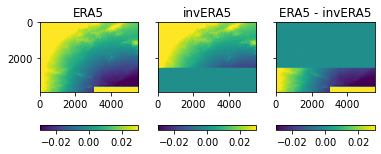

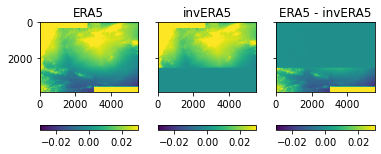

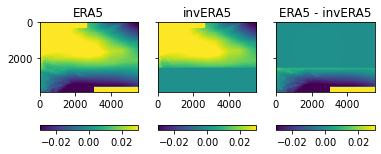

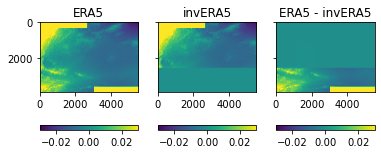

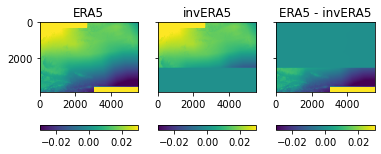

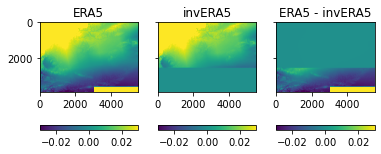

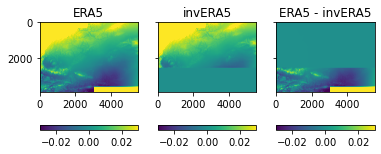

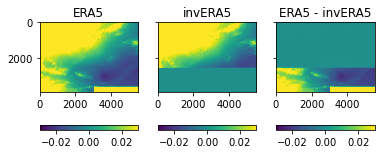

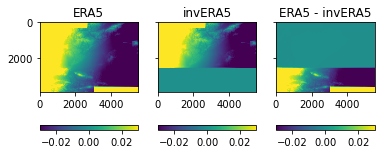

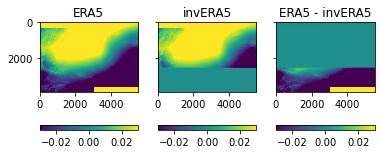

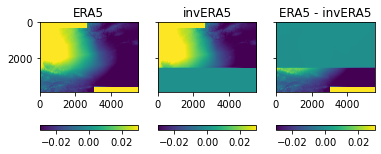

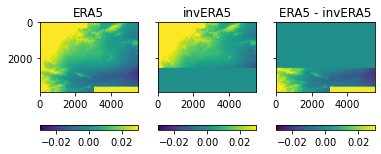

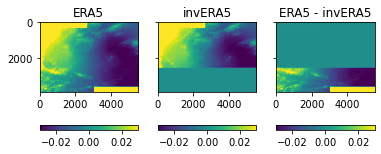

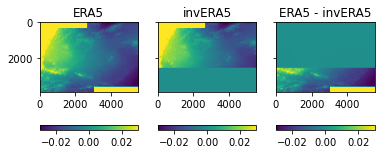

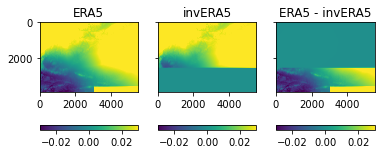

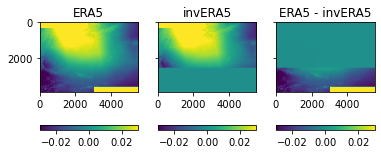

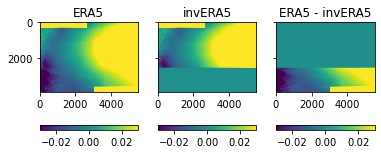

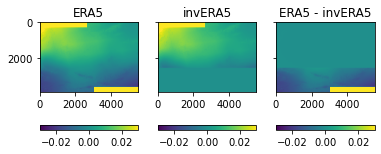

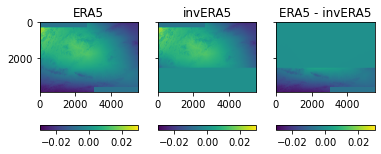

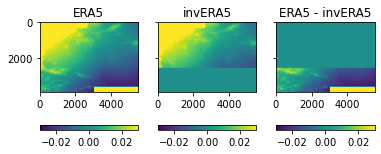

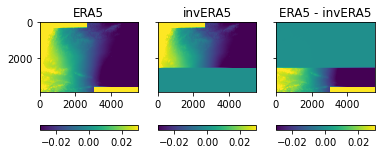

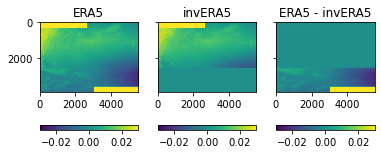

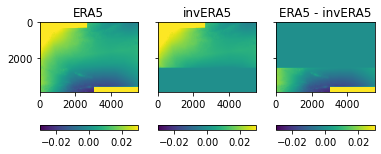

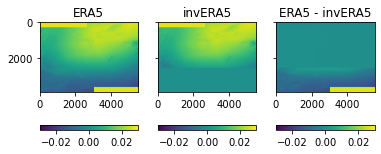

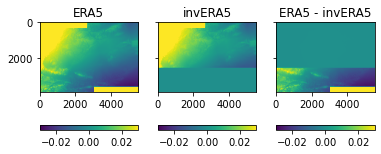

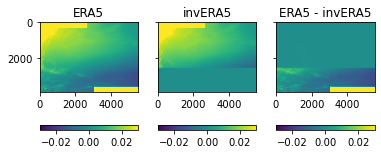

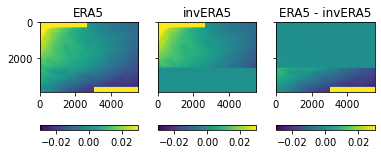

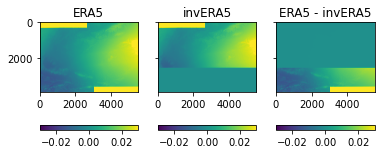

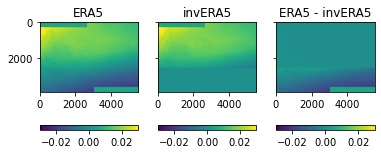

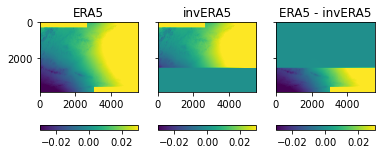

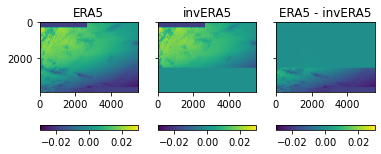

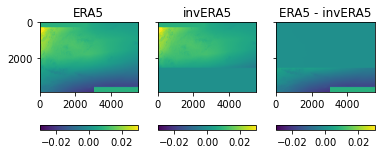

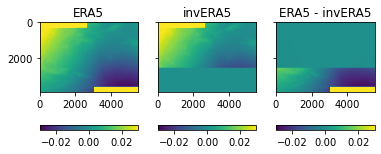

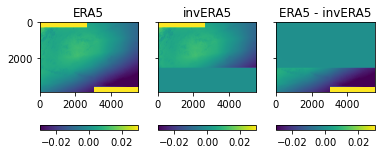

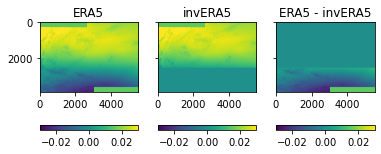

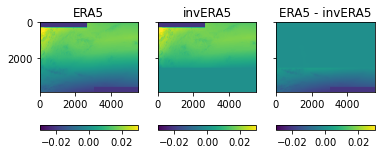

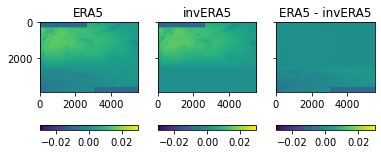

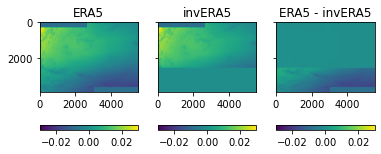

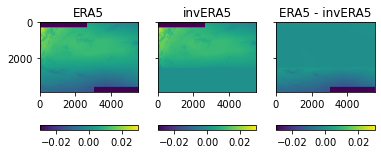

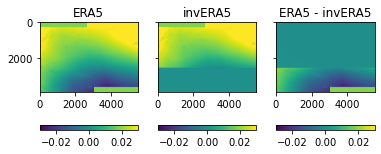

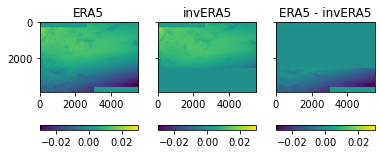

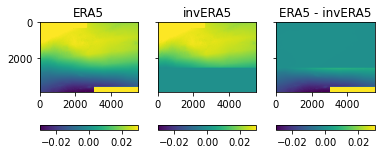

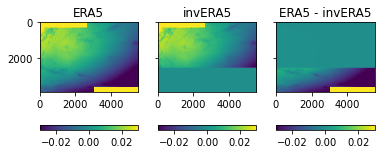

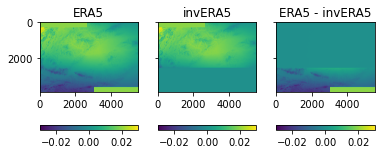

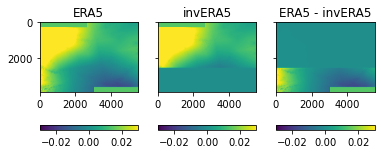

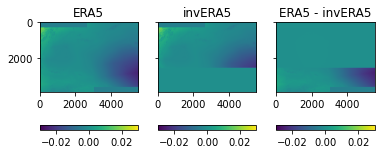

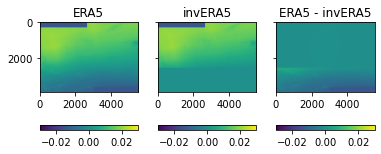

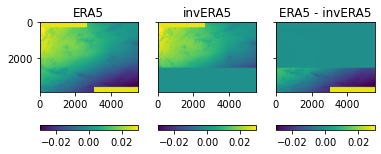

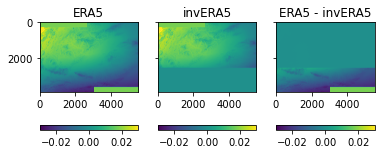

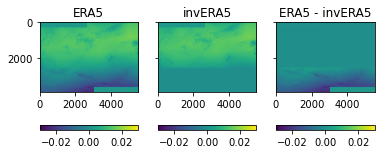

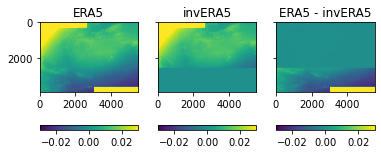

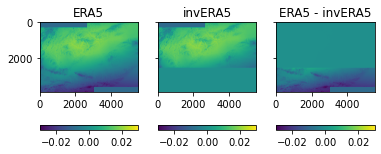

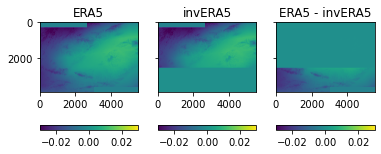

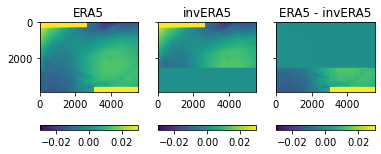

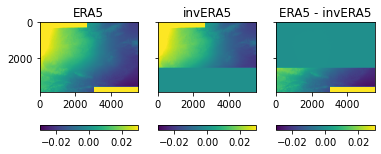

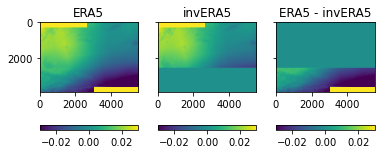

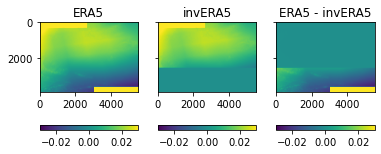

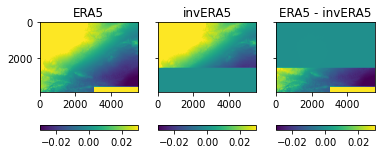

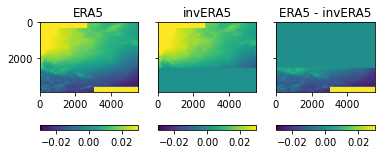

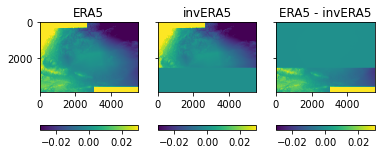

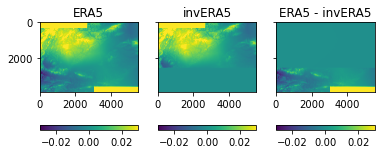

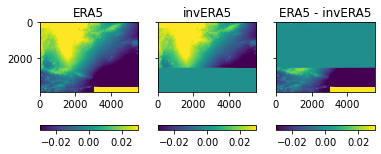

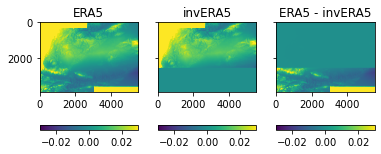

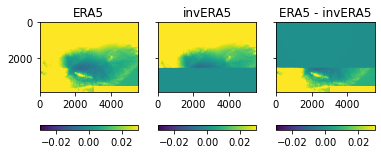

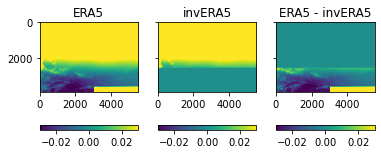

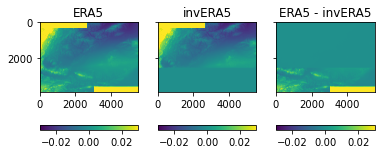

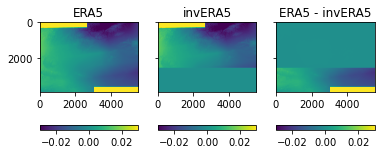

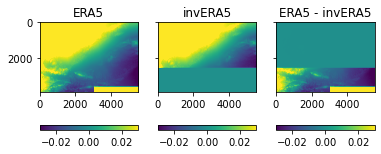

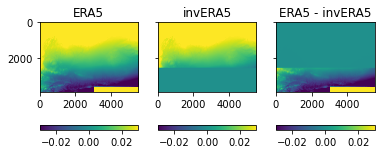

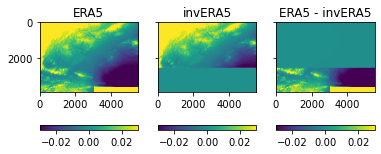

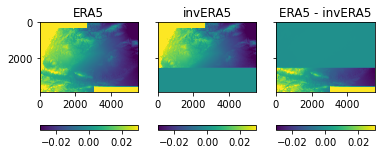

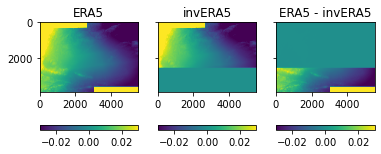

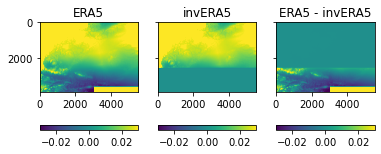

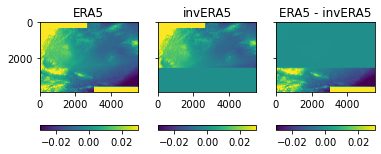

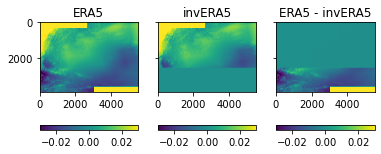

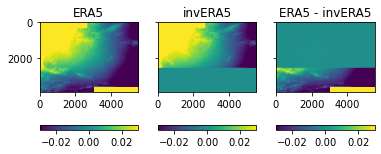

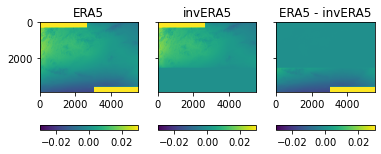

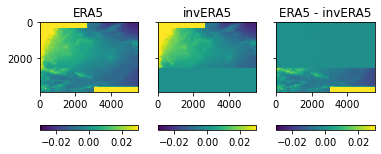

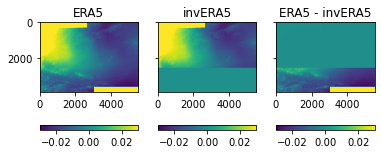

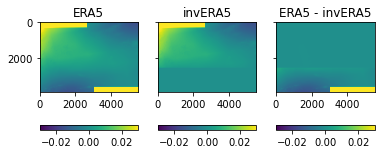

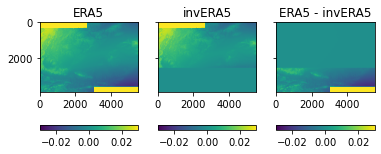

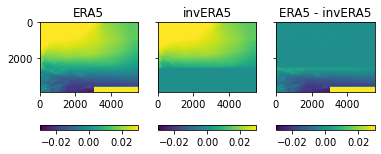

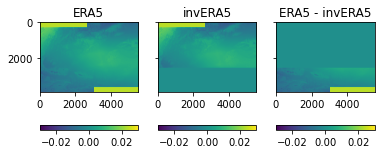

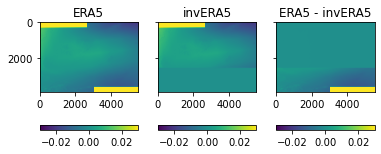

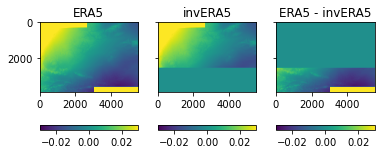

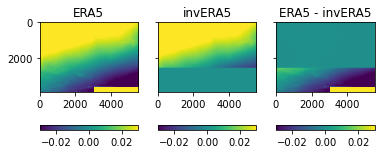

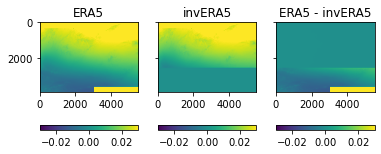

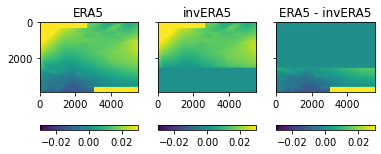

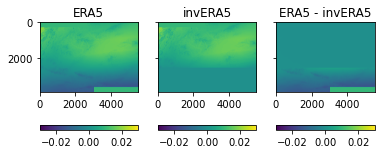

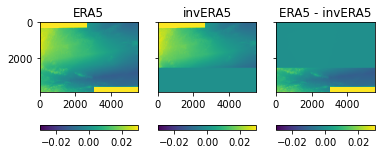

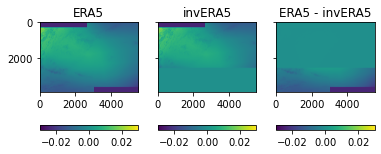

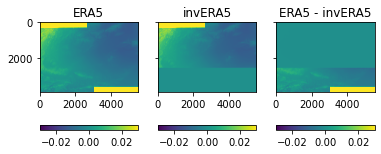

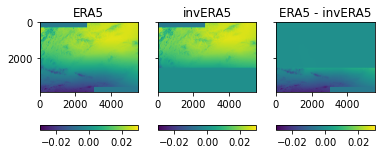

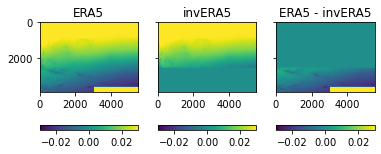

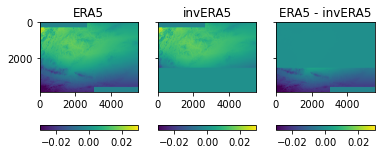

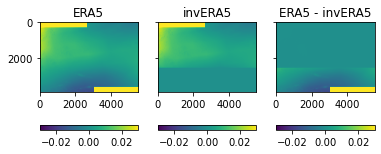

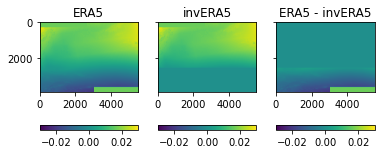

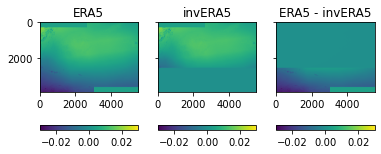

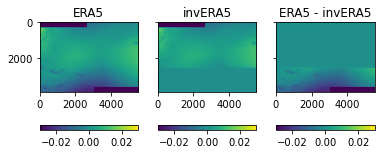

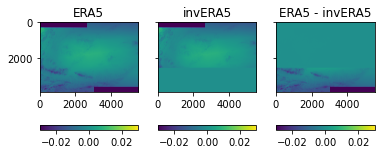

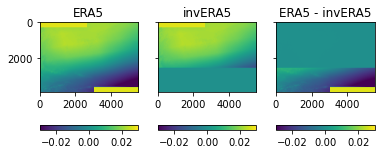

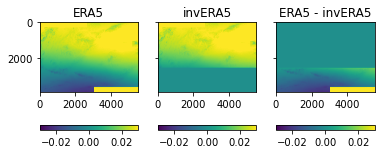

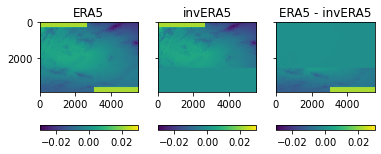

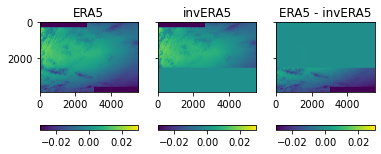

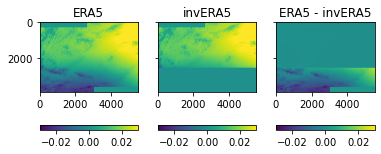

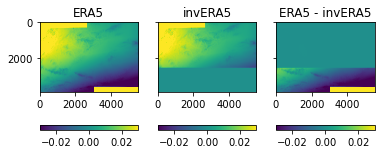

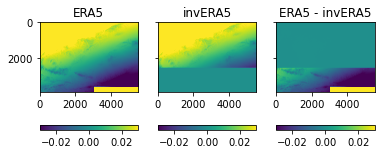

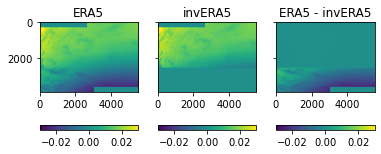

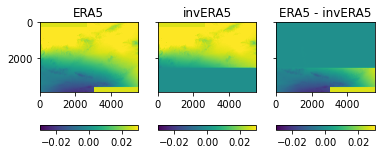

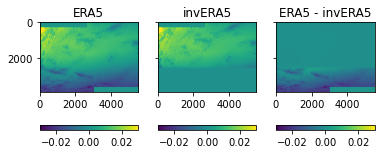

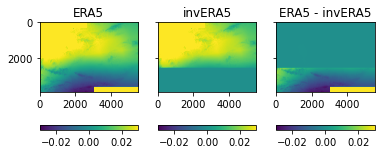

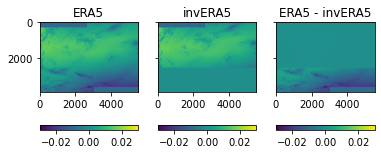

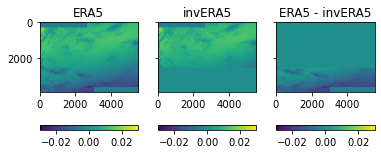

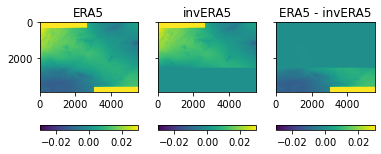

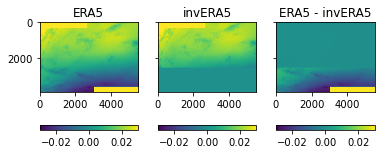

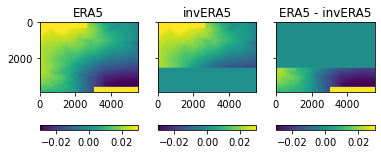

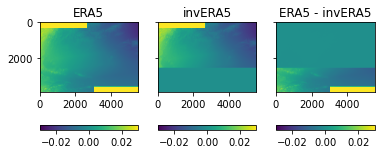

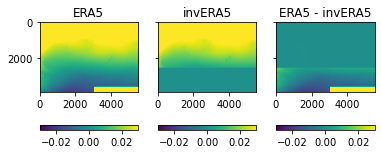

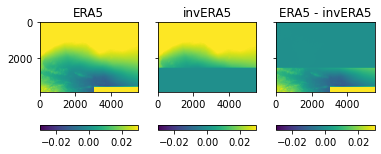

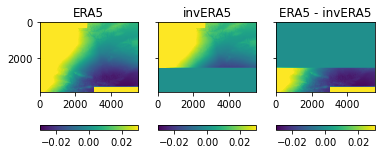

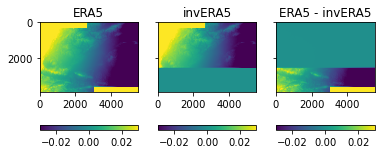

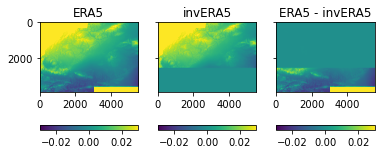

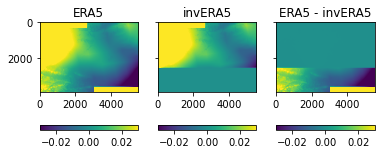

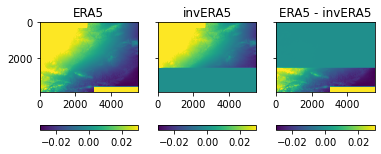

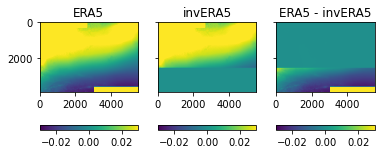

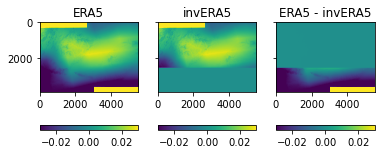

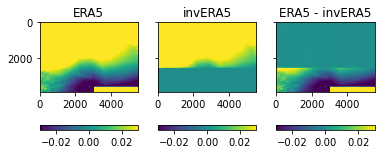

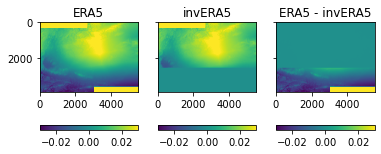

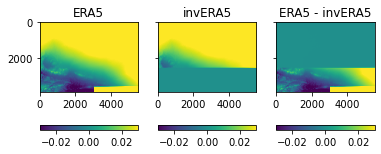

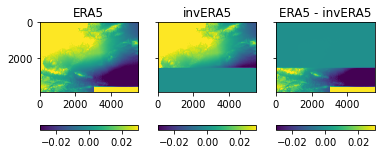

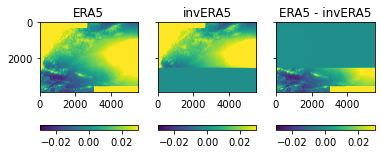

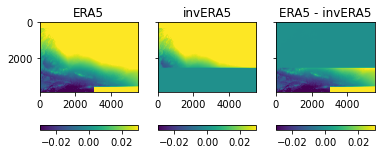

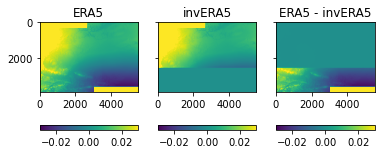

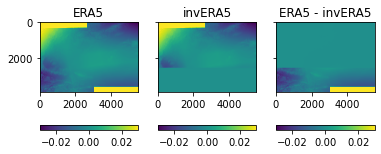

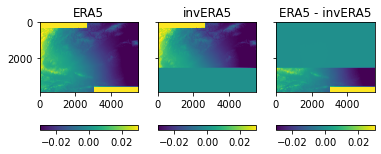

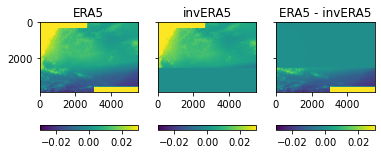

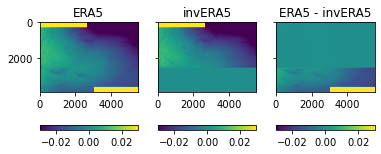

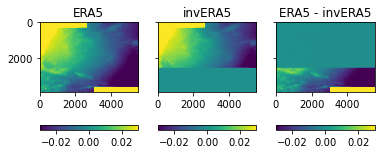

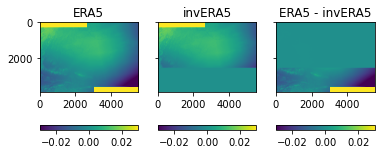

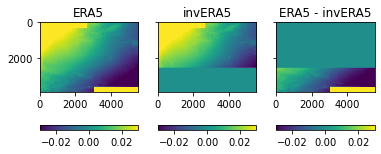

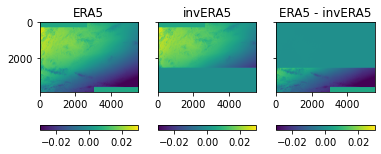

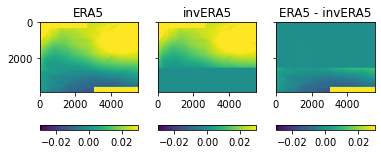

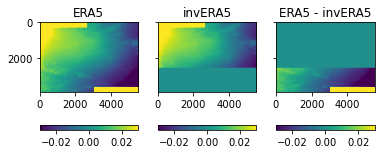

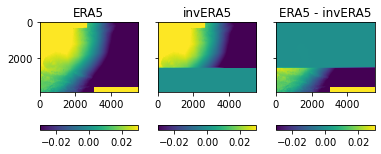

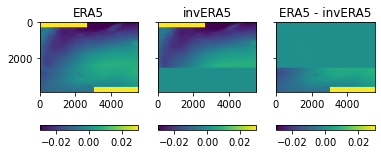

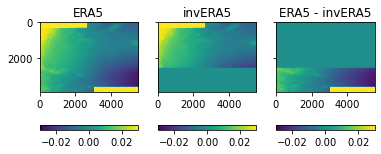

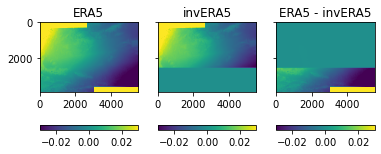

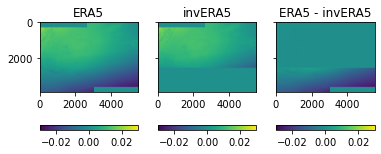

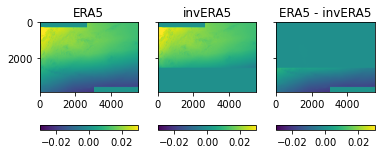

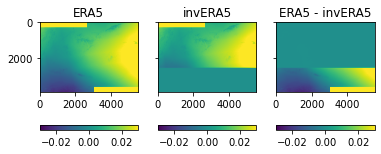

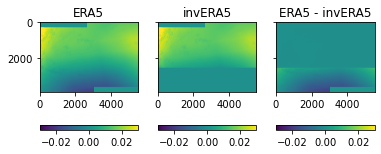

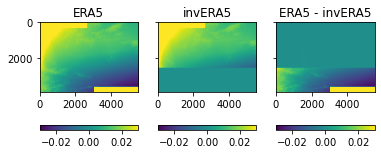

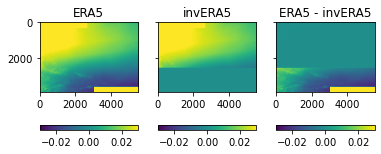

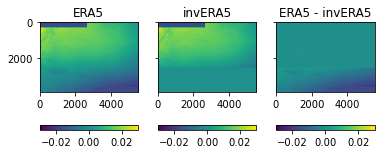

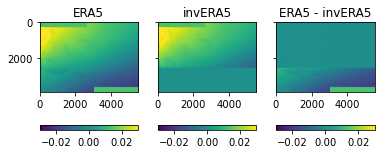

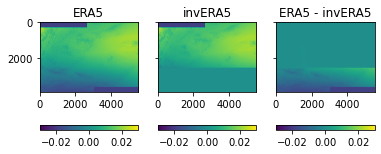

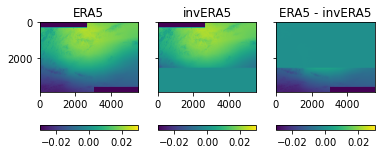

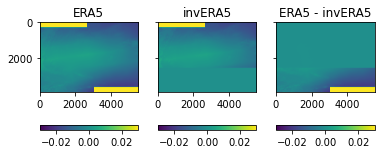

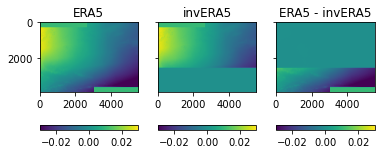

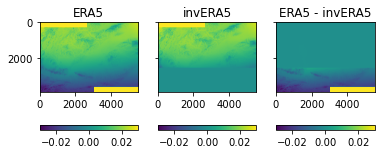

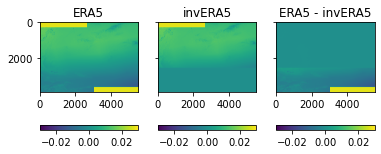

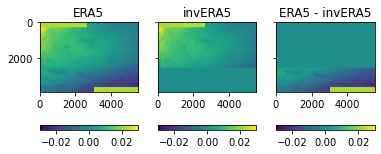

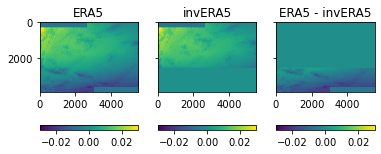

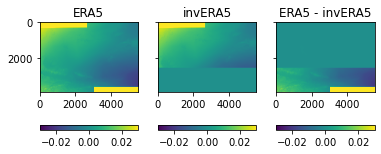

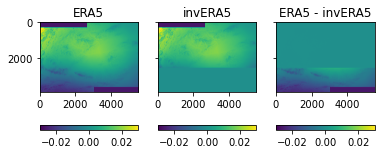

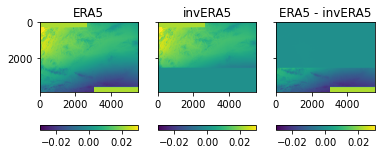

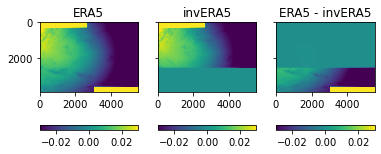

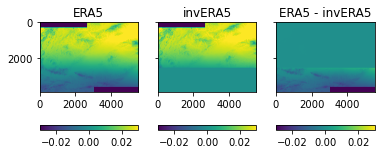

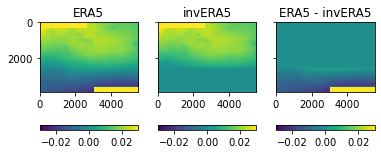

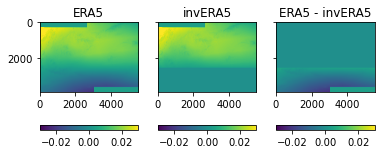

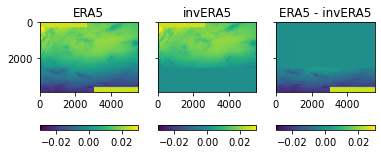

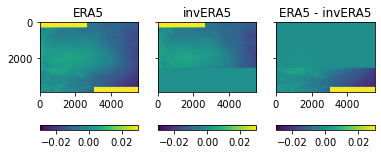

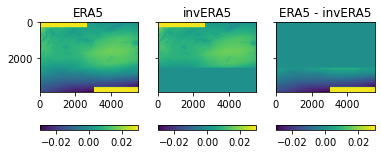

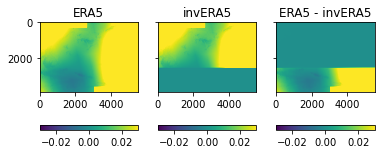

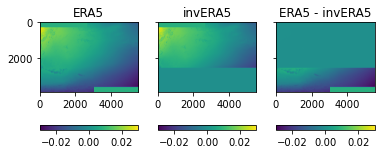

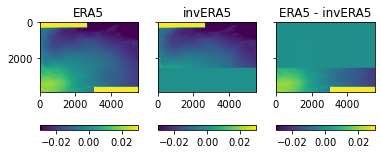

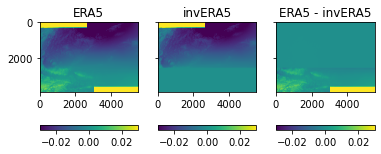

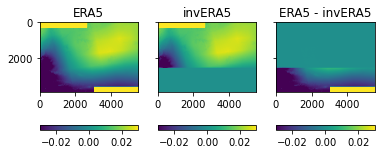

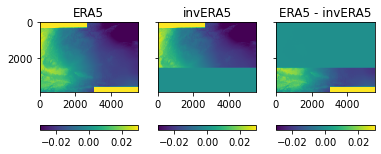

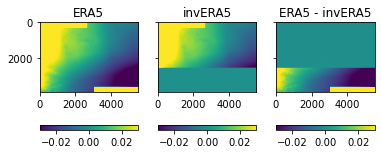

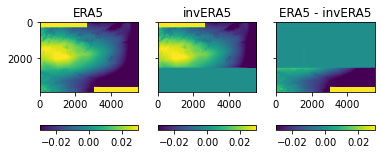

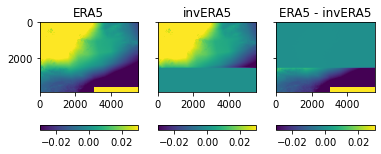

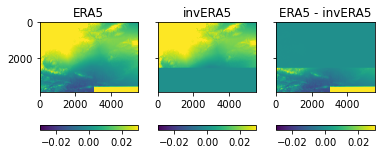

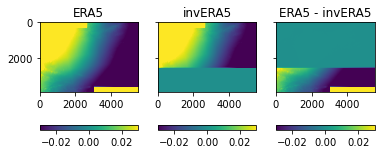

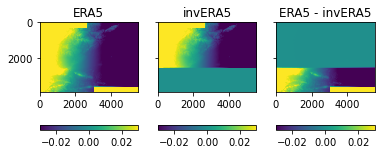

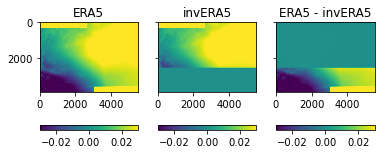

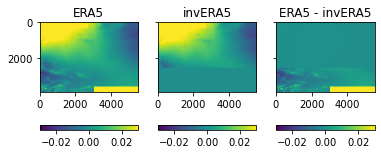

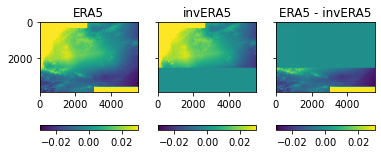

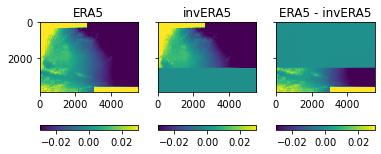

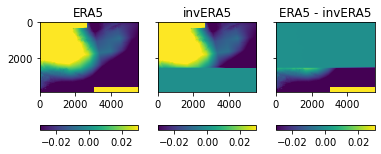

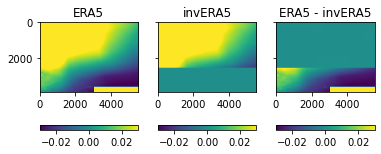

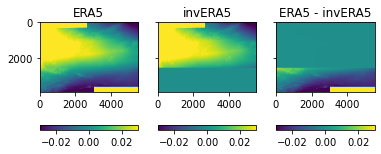

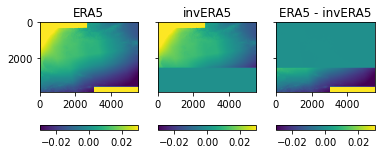

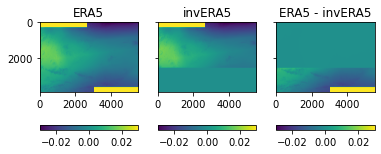

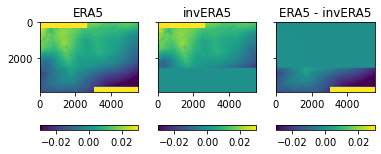

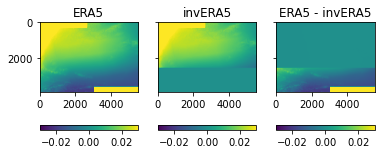

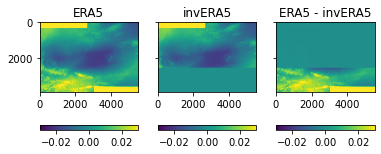

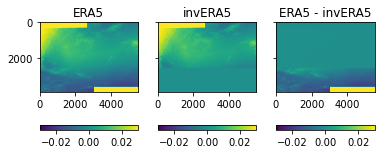

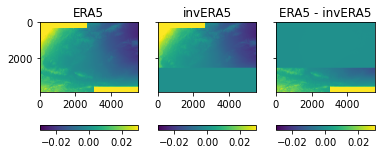

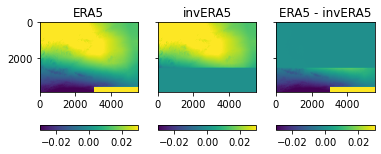

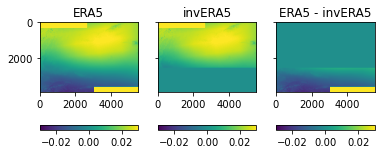

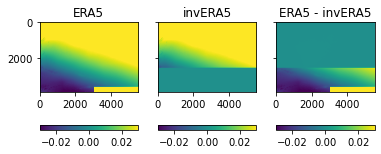

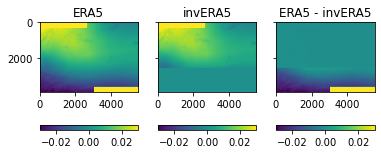

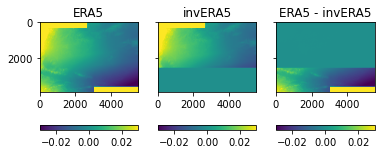

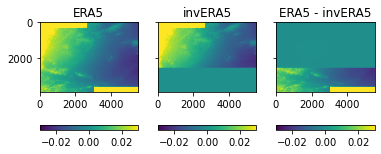

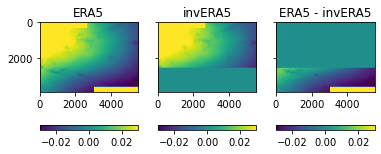

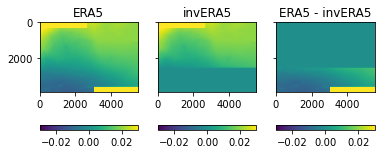

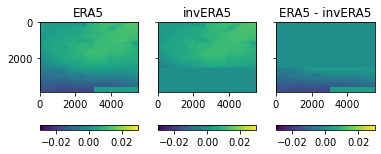

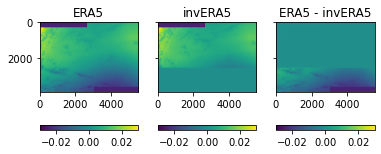

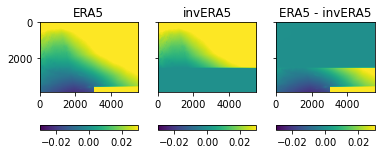

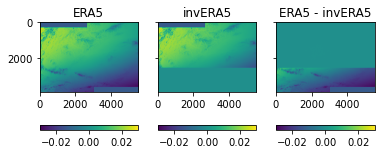

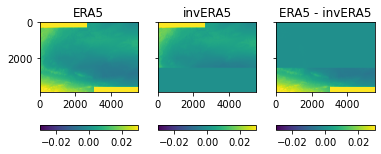

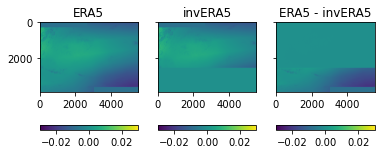

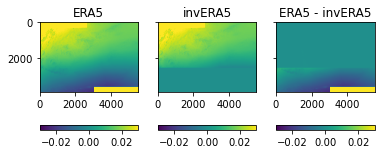

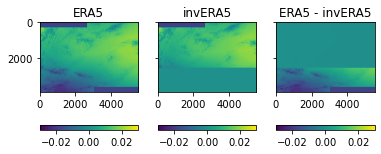

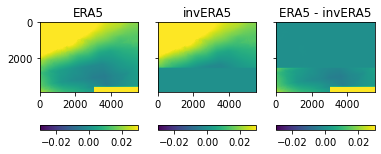

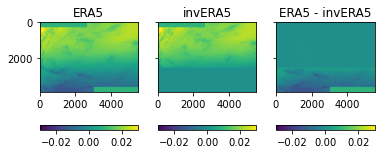

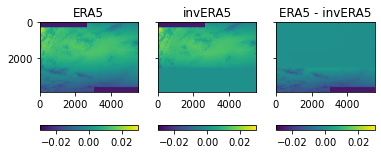

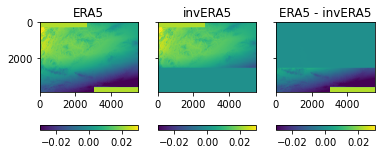

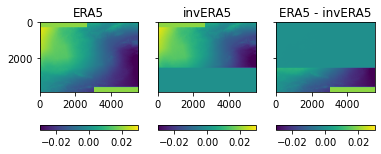

In [20]:
for e1, e2 in zip(era5[0], t_era5[0]):
    plot_tropo(e1, e2, era5[0][0])